続きからやること
1. 対数化をpipeにするとこから
2. 次々の特徴量をpipeで書いていく

### コンペ概要

* 目的：関東地方のさまざまな不動産情報をもとに、各不動産の最終価格を予想するコンペです。
  * 実際に取引された価格のニュアンスでいいはず
* 評価関数：RMSLE(二乗平均平方根対数誤差)
* 提出物
  1. コンペとしての結果（普通にやればいい）
  2. それに使ったノートブックファイル
     1. EDA（探索的分析）の結果としてグラフを1つ以上出力すること。
     2. データの分割方法について記述すること。
     3. 出力結果を残した状態で提出すること。 

なので、ファイルを横展開するのは現実的ではない（その後にまとめる必要があるので）

* 提出上限　1日3件

### 方針

* EDAをする
* 使えるデータだけで一旦爆速提出


### 目標（後で消す）

* 一位をとる　業務に支障が出ない範囲で
* pipeを使う
  * EDAに対してはあまり有効ではないのでは？（すぐに結果を見たいので）
  * どの列に対しても、似通った操作をしたいことはあるし、関数を１箇所にしておけば可読性が上がるからpipeの意味はありそう

### EDA

trainデータの特徴
* 646308行*35列のデータ(かなり学習しがいがありそう)
* 目的変数はtradeprice

各列の特徴,どのように処理するか
1. id:識別番号 
  * 無視（というか削除）でいい
2. Type:不動産の種類
3. Region:周辺地域の特徴
4. MunicipalityCode:市外局番
5. Prefecture:都道府県名
6. Municipality:市の名前
7. District:地区名
8. NearestStation:最寄りの駅名
9. TimeToNearestStation:最寄りの駅までの時間（文字値を含む）
10. MinTimeToNearestStation:TimeToNearestStation から生成される最寄りの駅までの最小時間 (分)
11. MaxTimeToNearestStation:TimeToNearestStation から生成される最寄りの駅までの最大時間 (分)
12. TradePrice： 取引価格（円）目標
    1.  目的変数
13. FloorPlan：フロアプラン
14. Area：調査面積 (m^2)
15. AreaIsGreaterFlag：2000 m^2 以上のエリア、エリア データは 2000 で表示され、このフラグは true
16. LandShape：土地の形状
17. Frontage： 間口(m)
18. FrontageIsGreaterFlag：一部の元の間口データには「50.0m 以上」と記録されているため、間口を数値に変換してこのフラグを追加しました
19. TotalFloorArea：延床面積 (m^2)
20. TotalFloorAreaIsGreaterFlag： 一部のデータは「2,000 m^2 以上」と表示されるため、TotalFloorArea を数値に変換してこのフラグを追加しました
21. BuildingYear：建物の建設年
22. PrewarBuilding：1945年以前に建てられた建物については、建築年データを「戦前」と表示しています。そこで、Build Year を 1945 に変換し、このフラグを追加しました
23. Structure：建物の構造。SRC=鉄骨鉄筋コンクリート造、RC=鉄筋コンクリート造、S=鉄骨造、LS=軽量鉄骨造、B=コンクリートブロック造、W=木造
24. Use：現在の使用状況。例：住宅、オフィス、店舗、工場、倉庫、作業場、駐車場など
25. Purpose：将来の使用目的。たとえば、住宅、店舗、オフィス、工場、倉庫などです。
26. Direction： 側道方向
27. Classification：側道区分
28. Breadth：間口道路幅員（m）
29. CityPlanning：都市計画法に基づく用途地
30. CoverageRatio：最大建蔽率(%)
31. FloorAreaRatio：最大容積率(%)
32. Year：期間から生成されたトランザクション年の時
33. Quarter：期間から生成されたトランザクションの年-四半期の時刻
34. Renovation：リノベーション？
35. Remarks：注記

数値として適応されているデータと、その数値が一定を超えた時にフラグが発生しているイメージ

## 関数セル

In [17]:
# モジュール読み込みセル
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import StandardScaler


In [48]:
# pipe用関数セル

#　0.データの読み込み
def load_data(path):
    return pd.read_csv(path)

# 0-1.データフレームの表示
def head_data(df):
    display(df.head())
    return df
# 0-2.欠損値情報について
def get_info(df):
    display(df.info())
    return df
# 1.統計量の表示
def get_describe(df,name='TradePrice'):
    pd.set_option('display.float_format', '{:.2f}'.format)
    print(df[name].describe())
    return df
# 2.箱ひげ図
def make_barplot(df,name='TradePrice'):
    sns.boxplot(data=df[f"{name}"])
    plt.show()
    return df

# 3.tradepriceを昇順（降順）に表示
def sort_tradeprice(df,ascending_=False, gg=20):
    display(df['TradePrice'].sort_values(ascending=ascending_).head(gg))
    return df
# 3-1-0 .外れ値の算出関数 外れ値の確認だけをしている
def check_outrange(df, name='TradePrice'):
    # 四分位範囲による外れ値の算出
    Q1 = df[name].quantile(0.25)
    Q3 = df[name].quantile(0.75)
    IQR = Q3 - Q1
    # 外れ値（下）を算出
    out_under = Q1-1.5*IQR
    # 外れ値（上）を算出
    out_over = Q3+1.5*IQR
    print(f"下の外れ値：{out_under} 上の外れ値：{out_over}")
    return df, out_under,out_over

# 3-1-1. 外れ値のみの統計量や分布
def outrange_describe(df,name_='TradePrice'):
    df, out_under,out_over = check_outrange(df, name=name_) 
    # 外れ値の下側は存在しないので今回は書かない
    df_ov =df[df[name_] > out_over]
    print('外れ値について ========')
    df_ov =(
        df_ov
        # 統計量の表示
        .pipe(get_describe)
        # histgramの図示
        .pipe(make_histplot)
    )
    print('====================')
    return df

# 3-1-2. 外れ値を除外したデータを返す
def dev_outrange(df,name_='TradePrice'): 
    df, out_under,out_over = check_outrange(df, name=name_)
    df_innerrange =df[(out_under < df[name_]) & (df[name_]<out_over)]
    # 外れ値を除くのであれば、この関数を使えばいいし
    # 使わないのであれば、このpipeを除けばいいので問題はない
    print(f"外れ値を除いた個数：{len(df_innerrange)}")
    return df_innerrange

# 3-1.外れ値を除外して,ヒストグラムを表示
def innnerrange(df, name='TradePrice'):
    # 外れ値を除く処理
    df_innerrange = dev_outrange(df,name_=name)
    # 外れ値を除いたものに対して、ヒストグラムを表示
    df_innerrange = make_histplot(df_innerrange,bin=8)
    return df

# 4.histplotの図示
def make_histplot(df,name='TradePrice' ,bin=10,types=None):
    df_1 = df.copy()
    if types == 'standard':
        df_1 = make_standerdscaler(df_1)
    elif types == 'log':
        df_1 = make_log(df_1)
    sns.histplot(df_1[f"{name}"],bins=bin,kde=True)
    plt.show()
    return df

# 5. 対数化
def make_log(df, name_='TradePrice'):
    # 対数化してデータに返す
    df[name_] = np.log1p(df[name_])
    return df
# 6. 標準化による正規化
def make_standerdscaler(df,name='TradePrice'):
    scalar = StandardScaler()
    df[name] = scalar.fit_transform(df[[name]])
    return df
    

In [44]:
# trainデータ読み込み
train =(
    load_data('estyle-2023/train.csv')
)

データ全体の情報を確認

In [31]:
result = (
train
.pipe(head_data)
.pipe(get_info)
)

,Id,Type,Region,MunicipalityCode,Prefecture,Municipality,DistrictName,NearestStation,TimeToNearestStation,MinTimeToNearestStation,...,Direction,Classification,Breadth,CityPlanning,CoverageRatio,FloorAreaRatio,Year,Quarter,Renovation,Remarks
0,1,Agricultural Land,NaN,12212,Chiba Prefecture,Sakura City,Iwatomi,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,2016,4,NaN,Dealings in which auction or arbiter participates
1,2,Residential Land(Land and Building),Residential Area,11105,Saitama Prefecture,"Chuo Ward,Saitama City",Shimoochiai,Yonohonmachi,4,4.00,...,North,City Road,4.00,Category II Exclusively Medium-high Residentia...,60.00,200.00,2015,1,NaN,NaN
2,3,Residential Land(Land Only),Residential Area,13114,Tokyo,Nakano Ward,Minamidai,Nakanofujimicho,19,19.00,...,Southwest,Private Road,4.00,Category I Exclusively Medium-high Residential...,60.00,200.00,2012,4,NaN,Dealings including private road
3,4,Residential Land(Land Only),Residential Area,14152,Kanagawa Prefecture,"Chuo Ward,Sagamihara City",Fuchinobehoncho,Fuchinobe,16,16.00,...,Southwest,Private Road,5.00,Category I Exclusively Low-story Residential Zone,50.00,80.00,2013,2,NaN,NaN
4,5,Residential Land(Land and Building),Residential Area,14152,Kanagawa Prefecture,"Chuo Ward,Sagamihara City",Tana,Kamimizo,30-60minutes,30.00,...,Northwest,City Road,6.00,Category I Exclusively Low-story Residential Zone,50.00,80.00,2012,4,NaN,NaN


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 646308 entries, 0 to 646307
Data columns (total 35 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   Id                           646308 non-null  int64  
 1   Type                         646308 non-null  object 
 2   Region                       450280 non-null  object 
 3   MunicipalityCode             646308 non-null  int64  
 4   Prefecture                   646308 non-null  object 
 5   Municipality                 646308 non-null  object 
 6   DistrictName                 645986 non-null  object 
 7   NearestStation               623397 non-null  object 
 8   TimeToNearestStation         615944 non-null  object 
 9   MinTimeToNearestStation      615944 non-null  float64
 10  MaxTimeToNearestStation      606046 non-null  float64
 11  TradePrice                   646308 non-null  int64  
 12  FloorPlan                    168800 non-null  object 
 13 

None

* 欠損値を持った列がそれなりにあるのでどう処理をするか
* ざっと見た感じ文字列が多いのでうまく処理をしたい

### TradePrice(目的変数)

* [2021年における不動産取引最高額が5兆円ごえなので最大値はありえる](https://www.nli-research.co.jp/report/detail/id=71296?site=nli)
* 最小額は100万円とかなので、100円は考えにくい

count   646308.00
mean         0.00
std          1.00
min         -0.22
25%         -0.16
50%         -0.09
75%         -0.01
max        256.71
Name: TradePrice, dtype: float64


C:\pg\Python39\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\pg\Python39\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


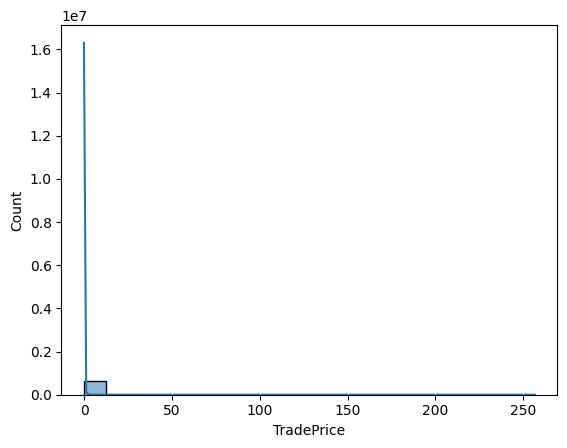

128447   256.71
129252   147.38
447707   125.51
504904   120.05
397346   114.58
290622   103.65
334930    98.18
310725    98.18
248151    87.25
35461     81.78
239008    81.78
298000    81.78
313327    81.78
595409    81.78
135695    76.31
826       76.31
335901    76.31
438735    76.31
397723    76.31
473290    76.31
Name: TradePrice, dtype: float64

39400    -0.22
357188   -0.22
117148   -0.22
402283   -0.22
585924   -0.22
313606   -0.22
318641   -0.22
130914   -0.22
61952    -0.22
335016   -0.22
191379   -0.22
301502   -0.22
614346   -0.22
607179   -0.22
107192   -0.22
339728   -0.22
610117   -0.22
193682   -0.22
327157   -0.22
178713   -0.22
Name: TradePrice, dtype: float64

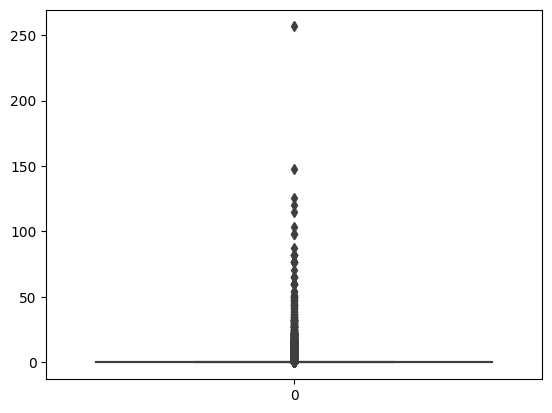

下の外れ値：-0.39041557628905976 上の外れ値：0.22185501697554738
外れ値について ========
count   40559.00
mean        1.28
std         3.75
min         0.22
25%         0.32
50%         0.54
75%         1.09
max       256.71
Name: TradePrice, dtype: float64


C:\pg\Python39\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\pg\Python39\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


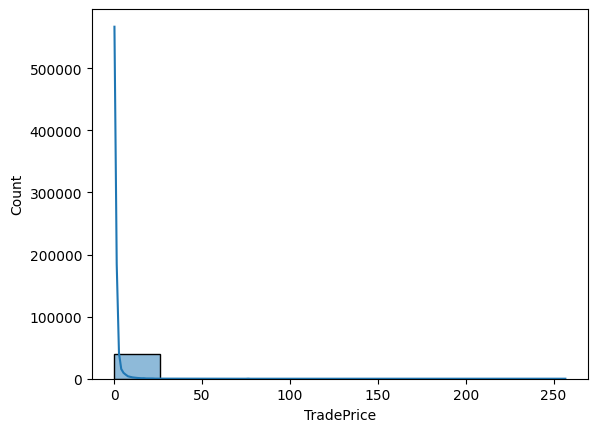

下の外れ値：-0.39041557628905976 上の外れ値：0.22185501697554738
外れ値を除いた個数：605749


C:\pg\Python39\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\pg\Python39\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


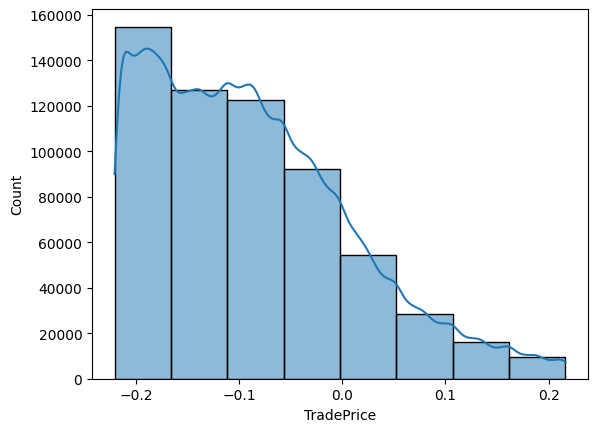

C:\pg\Python39\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\pg\Python39\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


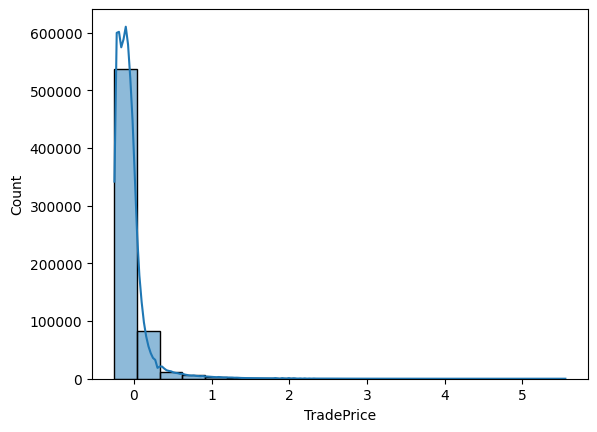

TypeError: make_histplot() got an unexpected keyword argument 'kde'

In [55]:
# pipe実行セル1
result =(
    train
    .pipe(get_describe) # 統計量を表示
    .pipe(make_histplot, bin=20) # ヒストグラムの表示
    .pipe(sort_tradeprice) # 大きい順に２０桁表示
    .pipe(sort_tradeprice,ascending_=True)# 小さい順に２０件表示
    .pipe(make_barplot) # 箱ひげ図を作成
    .pipe(outrange_describe) # 外れ値の統計量
    .pipe(innnerrange) # 外れ値でない値のヒストグラム
    .pipe(make_histplot, types='log',bin=20) # 対数の表示
    .pipe(make_histplot, types='standard', bin=5) #標準化の表示
)

* describe
  * 最小値100円、最大値470億円とかなり幅がある
  * 金額の分布を知りたい、数値として、上限下限の値を知りたい
* histgram
  * 最大値が多すぎるせいかうまく表示されない
  * 端っこの値を確認したい
* ascending
  * 値の一番端の値のみが触れているというわけではない
* 箱ひげ図
  * 最大値がかなり飛び抜けていることがわかる
  * 正規性はあるか確認したい
* 最小値、最大値
  * 最小値のみが大きく外れいると思ったがそういう訳でもなさそう
  * 考えられること：桁数の入力忘れ、知人間でタダ同然に渡したなど
* 外れ値の統計量
  * 。。。。
* 外れ値を除いたhistgram
  * 外れ値そのもの：大体4万（７％くらい）件省かれているので、無視していい量ではない
  * ヒストグラム：200万円までの値で全体の半分くらいを網羅していそう
    * 100万円単位で、個数が単調減少している
* 対数化
  * かなり外れ値の影響を受けづらいデータとなった
  * 予測時は、対数化した方が精度たかくなりそう
* 標準化
  * 結局外れ値のえいきょうを大きくうけてしまう
  * 標準化をしたときに最大値が256なのだから、図がおかしくなるのは妥当

### 引き続きEDA